In [1]:
data_path = "D:/Huge datasets/avito/data"
PAD_LEN_WORD = 35
PAD_LEN_CHAR = 20
N_VECTORS = 80000
EMB_DIM = 300
MAX_VOCAB = 4000
MAX_CHAR = 125

from keras.preprocessing import sequence
from keras.layers.merge import concatenate

C:\Users\arman\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os

In [162]:
from text_prep import Preparator

In [169]:
pr = Preparator()

In [170]:
train = os.path.join(data_path, "train.csv.zip")
word_vectors_path = os.path.join(data_path, "wiki.ru.vec") # bunch of russian w2v http://rusvectores.org/en/models/

In [171]:
train = pd.read_csv(train,compression="zip",nrows = 50000)
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [172]:
vectors = pr.load_vectors(word_vectors_path, N_VECTORS)

In [173]:
train[["description", "title", "param_1", "param_2", "param_3"]] = train[["description", "title", "param_1", "param_2", "param_3"]].fillna('__NA__')

In [207]:
import re
from string import punctuation
from nltk import sent_tokenize

regex = re.compile('[%s]' % re.escape(punctuation))
struct = "/\n✔;"
struct = re.compile('[%s]' % re.escape(struct))
train['price'] = train['price'].fillna(train['price'].median())
train[["description", "title"]] = train[["description", "title"]].fillna('__NA__')

train["text"] = train.apply(lambda x: x["title"] + " END_DESC " + x["description"], axis=1)
train["text_len"] = train.text.map(len)
train["nb_words"] = train.text.map(lambda x: len(x.split()))
train["nb_sents"] = train.text.map(lambda x: len(sent_tokenize(x)))
train["nb_punct"] = train.text.map(lambda x: len(regex.findall(x)))
train["words_price"] = train.apply(lambda x: x['price']/x["nb_words"], axis = 1 ) # longer description for more expensive products
# ex a long description for flat is more important than for shoes..

train['structure'] = train.text.map(lambda x: len(struct.findall(x))/len(x)) # structured text (bullet points carriage, returns etc..)
#ex: train.loc[451,"description"]
train["digits_count"] = train.text.map(lambda x: len(re.findall("\d+", x))/len(x))

## add postag embeddings rippletagger iin python2

## NER https://github.com/deepmipt/ner

In [175]:
from nltk.corpus import stopwords
russian_stops = stopwords.open('russian').read().splitlines()

def filter_params(param):
    return [w.lower() for w in param.split() if w.lower() not in russian_stops ]


## /!\ might be a little slow (optimize with re)
train['param_list'] = train.apply(lambda x: filter_params(x["param_1"]) +  filter_params(x["param_2"]) + filter_params(x["param_3"]), axis = 1)
train["parameter_match"] = train.apply(lambda x: any([w.lower() in x['param_list'] for w in x["text"].split()]), axis = 1) # can we find some parameters in text?


## category embedding
unique_cat = train.category_name.unique()
index2cat = {c: i for c, i in enumerate(unique_cat)}
cat2index = {v:k for k, v in index2cat.items()}

In [176]:
desc = pr.clean_col("text", train)

In [177]:
vocab, char_vocab = pr.create_vocab(desc, MAX_VOCAB , MAX_CHAR)

In [178]:
train_indexed = pr.vocab_lookup(desc ,vocab,  char_vocab)

In [179]:
mat, novect = pr.build_emb(vectors, vocab, EMB_DIM)

2965 words were found over a vocab of 4000 which is a ratio of 0.74


In [235]:
other_features = ["text_len", "nb_words", "nb_sents", "nb_punct",
                  "words_price", "structure", "digits_count", "price"]

other_features_dim = len(other_features)

padded_words = sequence.pad_sequences(train_indexed['word_id'], maxlen = PAD_LEN_WORD)
other_feat = [np.array(train[other_features])]
padded_text = [np.array(padded_words[:100000])]
#padded_chars = [sequence.pad_sequences(s, maxlen= PAD_LEN_CHAR) for s in train_indexed['char_id']]


In [250]:
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, Reshape
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D , GlobalAveragePooling1D, AveragePooling1D
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.initializers import RandomUniform

In [291]:
#training params
batch_size = 25 
num_epochs = 50

#model parameters
num_filters = 32 
EMB_DIM = 300 
weight_decay = 1e-7
CATEGORY_EMB_DIM = 5

num_classes = 1
nb_category = len(unique_cat)

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.pow(y_pred-y_true, 2)))

uniform = RandomUniform(
                        minval=-np.sqrt(3/CATEGORY_EMB_DIM),  # Suggested by
                        maxval= np.sqrt(3/CATEGORY_EMB_DIM))

In [295]:
text_input = Input((PAD_LEN_WORD,))
other_feat_input = Input((other_features_dim,))
category_input = Input((1, ))

m = Embedding(MAX_VOCAB + 1 , EMB_DIM,
          weights=[mat], input_length=PAD_LEN_WORD, trainable=False)(text_input)
m = Dropout(0.5)(m)
m = Conv1D(num_filters, 7, activation='relu', padding='same')(m)
m = AveragePooling1D(2)(m)
m = Conv1D(num_filters - 4, 7, activation='relu', padding='same')(m)
m = GlobalAveragePooling1D()(m)

category_emb = Embedding(input_dim=nb_category,
                        output_dim = CATEGORY_EMB_DIM,
                        input_length = 1,
                        trainable = True, 
                        embeddings_initializer=uniform )(category_input)

category_emb = Reshape((5, ))(category_emb)

category_emb = Dropout(0.2)(category_emb)

m = concatenate([category_emb, other_feat_input, m], axis = 1)
m = BatchNormalization()(m)

m = Dense(18, activation='relu')(m)
m = Dropout(0.2)(m)

m = Dense(4, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(m)

output = Dense(num_classes)(m)


model = Model(inputs=[category_input, other_feat_input, text_input] , 
              outputs= output,
              name='sec_model')
adam = optimizers.Adam(lr=0.0001, beta_1=0.9,
                       beta_2=0.999, epsilon=1e-08,
                       decay=0.0, clipnorm=2.)
model.compile(loss='mean_absolute_error',
              optimizer=adam,
              metrics=[rmse, "mae"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_134 (InputLayer)          (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_80 (Embedding)        (None, 35, 300)      1200300     input_134[0][0]                  
__________________________________________________________________________________________________
dropout_97 (Dropout)            (None, 35, 300)      0           embedding_80[0][0]               
__________________________________________________________________________________________________
input_136 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
conv1d_109

best training loss 0.6474

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)
callbacks_list = [early_stopping]


other_feat = [np.array(train[other_features])]
padded_text = [np.array(padded_words)]
category_data = [np.array(train.category_name.map(cat2index))]

target = np.array(train.deal_probability)
hist = model.fit( category_data + other_feat  + padded_text ,
                 target,
                 batch_size=batch_size,
                 epochs=num_epochs,
                 validation_split=0.1,
                 shuffle=True,
                 verbose=2, 
                 callbacks = callbacks_list)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
 - 41s - loss: 0.2558 - rmse: 0.4050 - mean_absolute_error: 0.2558 - val_loss: 0.1639 - val_rmse: 0.3371 - val_mean_absolute_error: 0.1639
Epoch 2/50
 - 39s - loss: 0.1486 - rmse: 0.2857 - mean_absolute_error: 0.1486 - val_loss: 0.1418 - val_rmse: 0.2912 - val_mean_absolute_error: 0.1418
Epoch 3/50
 - 43s - loss: 0.1415 - rmse: 0.2882 - mean_absolute_error: 0.1415 - val_loss: 0.1401 - val_rmse: 0.2867 - val_mean_absolute_error: 0.1401
Epoch 4/50
 - 43s - loss: 0.1406 - rmse: 0.2878 - mean_absolute_error: 0.1406 - val_loss: 0.1396 - val_rmse: 0.2856 - val_mean_absolute_error: 0.1396
Epoch 5/50
 - 39s - loss: 0.1404 - rmse: 0.2874 - mean_absolute_error: 0.1404 - val_loss: 0.1396 - val_rmse: 0.2858 - val_mean_absolute_error: 0.1396
Epoch 6/50
 - 40s - loss: 0.1403 - rmse: 0.2868 - mean_absolute_error: 0.1403 - val_loss: 0.1399 - val_rmse: 0.2865 - val_mean_absolute_error: 0.1399
Epoch 7/50


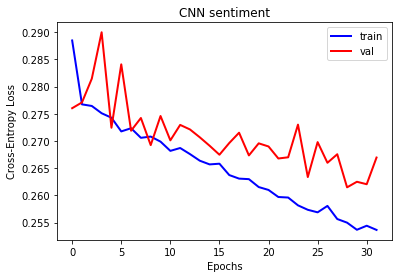

In [290]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(hist.history['rmse'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_rmse'], lw=2.0, color='r', label='val')

plt.title('CNN extra features')
plt.xlabel('Epochs')
plt.ylabel('rmse')
plt.legend(loc='upper right')
plt.show()

In [285]:
category_data[0]

array([0, 1, 2, ..., 5, 7, 0], dtype=int64)

simple features:
    - length of description.
    - number of words per sentence.
    - punctuation.
    - number of bullet points
    - location in description
    - brands
    - number of items (enumerations)
    - nb of words/Price
    - nb of words matching between parameters/region/city/category... and text
    
- extra features
    - images features (model IQA,  knn cluster, resized ratio)
    - 
    
- model improvement:
    - add more callbacks (ReduceLROnPlateau, CsvLogger for plotting different parameters, tensorboard... etc)
    - try different optimizers
    - try different architecture (ex add feature engeneering before the conv)
    - try new layer types ex: lSTM or atrousconv
    - add a lstm after the cnn
    - make smarter output layer based on target distri. (seems to be a pike at 0.7 -- Leakage)
    - make function for embedding cat variable, and add all embedding variables
    - try to put category variable as onehot encoded (might work better)
 
- stacking, ensembling several models:
    - try a linear fasttext (need modifiy the C code for regression, or binarize output)
    - add a tfidf naiveBayes + LR + xgboost
    - add other nets.
    - try finetuning the IQA on target while adding some raw text features.

In [265]:
np.random.randn(1, 4).reshape(4)

array([[-0.22107216, -0.90634358, -0.84760962, -0.3420023 ]])

In [377]:
train_indexed['char_id'][0]

[[316, 1129, 316, 1129, 49, 11, 316, 1129, 316, 1129, 1353],
 [444, 731, 2543],
 [16, 1353, 690]]

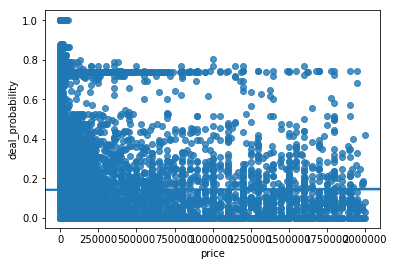

In [219]:
sub =  train[train.price < 2000000]
sns.regplot(sub.price, sub.deal_probability)

In [167]:
K.pow?